# Read and clean national data from ILO ES scenario and plot on map
Felix Zaussinger | 27.07.2021

## Core Analysis Goal(s)
1.
2.
3.

## Key Insight(s)
1.
2.
3.

In [16]:
import os
import sys
import logging
from pathlib import Path

import numpy as np
import scipy as sp
import statsmodels.api as sm
from statsmodels.formula.api import ols

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("poster")
sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("ticks")

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Define directory structure

In [17]:
# project directory
abspath = os.path.abspath('')
project_dir = str(Path(abspath).parents[0])

# sub-directories
data_raw = os.path.join(project_dir, "data", "raw")
data_interim = os.path.join(project_dir, "data", "interim")
data_processed = os.path.join(project_dir, "data", "processed")
figure_dir = os.path.join(project_dir, "reports", "figures")

Data

In [18]:
fpath = os.path.join(data_raw, "ilo_scenarios", "Employment 2030 country by industry_newksw_includingDifferences WORK ON IT.xlsx")

# 2°C - 6°C
df_delta = pd.read_excel(
    io=fpath,
    sheet_name="Employment 2030",
    header=[37, 38, 39],
    index_col=0,
    nrows=6,
).transpose()

df_delta.index.set_names(["country", "sector_code", "sector"], inplace=True)
df_delta *= 1000

In [19]:
# 2°C
df_deg2 = pd.read_excel(
    io=fpath,
    sheet_name="Employment 2030",
    header=[0,1,2],
    index_col=0,
    nrows=6,
).transpose()

df_deg2.index.set_names(["country", "sector_code", "sector"], inplace=True)
df_deg2 *= 1000

In [20]:
# 6°C
df_deg6 = pd.read_excel(
    io=fpath,
    sheet_name="Employment 2030",
    header=[13,14,15],
    index_col=0,
    nrows=6,
).transpose()

df_deg6.index.set_names(["country", "sector_code", "sector"], inplace=True)
df_deg6 *= 1000

In [21]:
import geopandas as gpd

In [22]:
shp_world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

In [23]:
# manually assign missing/misaligned country codes
shp_world.loc[shp_world.name == "France", "iso_a3"] = "FRA"
shp_world.loc[shp_world.name == "Romania", "iso_a3"] = "ROM"
shp_world.loc[shp_world.name == "Norway", "iso_a3"] = "NOR"

In [24]:
# higher resolution shapefile
f = gpd.read_file(os.path.join(data_raw, "ilo_scenarios", "ne_10m_admin_0_countries", "ne_10m_admin_0_countries.shp"))
fsub = f.query("REGION_UN == 'Europe' & ADMIN != 'Russia'")[["ADMIN", "POP_EST", "ISO_A3", "geometry"]]
fsub.columns = fsub.columns.str.lower()

fsub.loc[fsub.admin == "France", "iso_a3"] = "FRA"
fsub.loc[fsub.admin == "Norway", "iso_a3"] = "NOR"
fsub.loc[fsub.admin == "Romania", "iso_a3"] = "ROM"

In [25]:
fsub

,admin,pop_est,iso_a3,geometry
22,France,67106161,FRA,"MULTIPOLYGON (((-54.11153 2.11427, -54.13491 2..."
34,Ukraine,44033874,UKR,"MULTIPOLYGON (((31.76434 52.10057, 31.82584 52..."
35,Belarus,9549747,BLR,"POLYGON ((23.60624 51.51740, 23.60231 51.53078..."
44,Lithuania,2823859,LTU,"MULTIPOLYGON (((26.59453 55.66699, 26.60383 55..."
49,Czechia,10674723,CZE,"POLYGON ((14.81039 50.85845, 14.83168 50.85798..."
50,Germany,80594017,DEU,"MULTIPOLYGON (((13.81572 48.76643, 13.78586 48..."
51,Estonia,1251581,EST,"MULTIPOLYGON (((24.30616 57.86819, 24.31666 57..."
52,Latvia,1944643,LVA,"POLYGON ((27.35293 57.52760, 27.52817 57.52848..."
53,Norway,5320045,NOR,"MULTIPOLYGON (((20.62316 69.03636, 20.36272 69..."
54,Sweden,9960487,SWE,"MULTIPOLYGON (((20.62316 69.03636, 20.67546 69..."


In [26]:
# control step
country_codes = df_deg2.index.get_level_values("country").unique()
matches = [c if c in fsub.iso_a3.values else None for c in country_codes]

dict(zip(country_codes, matches))

{'AUT': 'AUT',
 'BEL': 'BEL',
 'BGR': 'BGR',
 'CYP': None,
 'CZE': 'CZE',
 'DEU': 'DEU',
 'DNK': 'DNK',
 'EST': 'EST',
 'ESP': 'ESP',
 'FIN': 'FIN',
 'FRA': 'FRA',
 'GRC': 'GRC',
 'HRV': 'HRV',
 'HUN': 'HUN',
 'IRL': 'IRL',
 'ITA': 'ITA',
 'LTU': 'LTU',
 'LUX': 'LUX',
 'LVA': 'LVA',
 'MLT': 'MLT',
 'NLD': 'NLD',
 'POL': 'POL',
 'PRT': 'PRT',
 'ROM': 'ROM',
 'SWE': 'SWE',
 'SVN': 'SVN',
 'SVK': 'SVK',
 'GBR': 'GBR',
 'USA': None,
 'JPN': None,
 'CHN': None,
 'CAN': None,
 'KOR': None,
 'BRA': None,
 'IND': None,
 'MEX': None,
 'RUS': None,
 'AUS': None,
 'CHE': 'CHE',
 'TUR': None,
 'TWN': None,
 'NOR': 'NOR',
 'IDN': None,
 'ZAF': None,
 'WWA': None,
 'WWL': None,
 'WWE': None,
 'WWF': None,
 'WWM': None}

In [27]:
df_delta["iso_a3"] = df_delta.index.get_level_values("country")

In [28]:
df_delta['Employment: Total'] = df_delta.sum(axis=1).values

In [29]:
gdf_delta = pd.merge(
    df_delta.reset_index(),
    fsub,
    on="iso_a3",
    how="left"
).set_index(["country", "sector_code", "sector"])

gdf_delta = gpd.GeoDataFrame(gdf_delta)

In [31]:
gdf_delta

Employment: Low-skilled male  \
country sector_code sector                                                                             
AUT     i01.a       Cultivation of paddy rice                                               0.000000   
        i01.b       Cultivation of wheat                                                    1.130526   
        i01.c       Cultivation of cereal grains nec                                        1.832343   
        i01.d       Cultivation of vegetables, fruit, nuts                                  2.578564   
        i01.e       Cultivation of oil seeds                                                0.269211   
...                                                                                              ...   
WWM     i91         Activities of membership organisation n.e.c. (91)                      15.569245   
        i92         Recreational, cultural and sporting activities ...                     75.589288   
        i93         Other service activities (93)                                          48.788949   
        i95         Private households with employed persons (95)                        2280.233671   
        i99         Extra-territorial organizations and bodies                              0.000000   

                                                                        Employment: Low-skilled female  \
country sector_code sector                                                                               
AUT     i01.a       Cultivation of paddy rice                                                 0.000000   
        i01.b       Cultivation of wheat                                                      0.491952   
        i01.c       Cultivation of cereal grains nec                                          0.793615   
        i01.d       Cultivation of vegetables, fruit, nuts                                    1.140581   
        i01.e       Cultivation of oil seeds                                                  0.117204   
...                                                                                                ...   
WWM     i91         Activities of membership organisation n.e.c. (91)                         5.041488   
        i92         Recreational, cultural and sporting activities ...                       36.134761   
        i93         Other service activities (93)                                            15.520385   
        i95         Private households with employed persons (95)                          6711.833194   
        i99         Extra-territorial organizations and bodies                                0.000000   

                                                                        Employment: Medium-skilled male  \
country sector_code sector                                                                                
AUT     i01.a       Cultivation of paddy rice                                                  0.000000   
        i01.b       Cultivation of wheat                                                       9.835479   
        i01.c       Cultivation of cereal grains nec                                          16.065838   
        i01.d       Cultivation of vegetables, fruit, nuts                                    22.892523   
        i01.e       Cultivation of oil seeds                                                   2.355670   
...                                                                                                 ...   
WWM     i91         Activities of membership organisation n.e.c. (91)                         25.126422   
        i92         Recreational, cultural and sporting activities ...                       120.165924   
        i93         Other service activities (93)                                             77.457913   
        i95         Private households with employed persons (95)                           1278.390976   
        i99         Extra-territorial organizations and 

i01.a Cultivation of paddy rice
i01.b Cultivation of wheat
i01.c Cultivation of cereal grains nec
i01.d Cultivation of vegetables, fruit, nuts
i01.e Cultivation of oil seeds
i01.f Cultivation of sugar cane, sugar beet
i01.g Cultivation of plant-based fibers
i01.h Cultivation of crops nec
i01.i Cattle farming
i01.j Pigs farming
i01.k Poultry farming
i01.l Meat animals nec
i01.m Animal products nec
i01.n Raw milk
i01.o Wool, silk-worm cocoons
i01.w.1 Manure treatment (conventional), storage and land application
i01.w.2 Manure treatment (biogas), storage and land application
i02 Forestry, logging and related service activities (02)
i05 Fishing, operating of fish hatcheries and fish farms; service activities incidental to fishing (05)
i10 Mining of coal and lignite; extraction of peat (10)
i11.a Extraction of crude petroleum and services related to crude oil extraction, excluding surveying
i11.b Extraction of natural gas and services related to natural gas extraction, excluding surveying
i

FileNotFoundError: [Errno 2] No such file or directory: '/Users/felix/ETH/code/rejet/reports/figures/ilo_es_maps/i90.1.g_Incineration_of_waste:_Oil/Hazardous_waste.png'

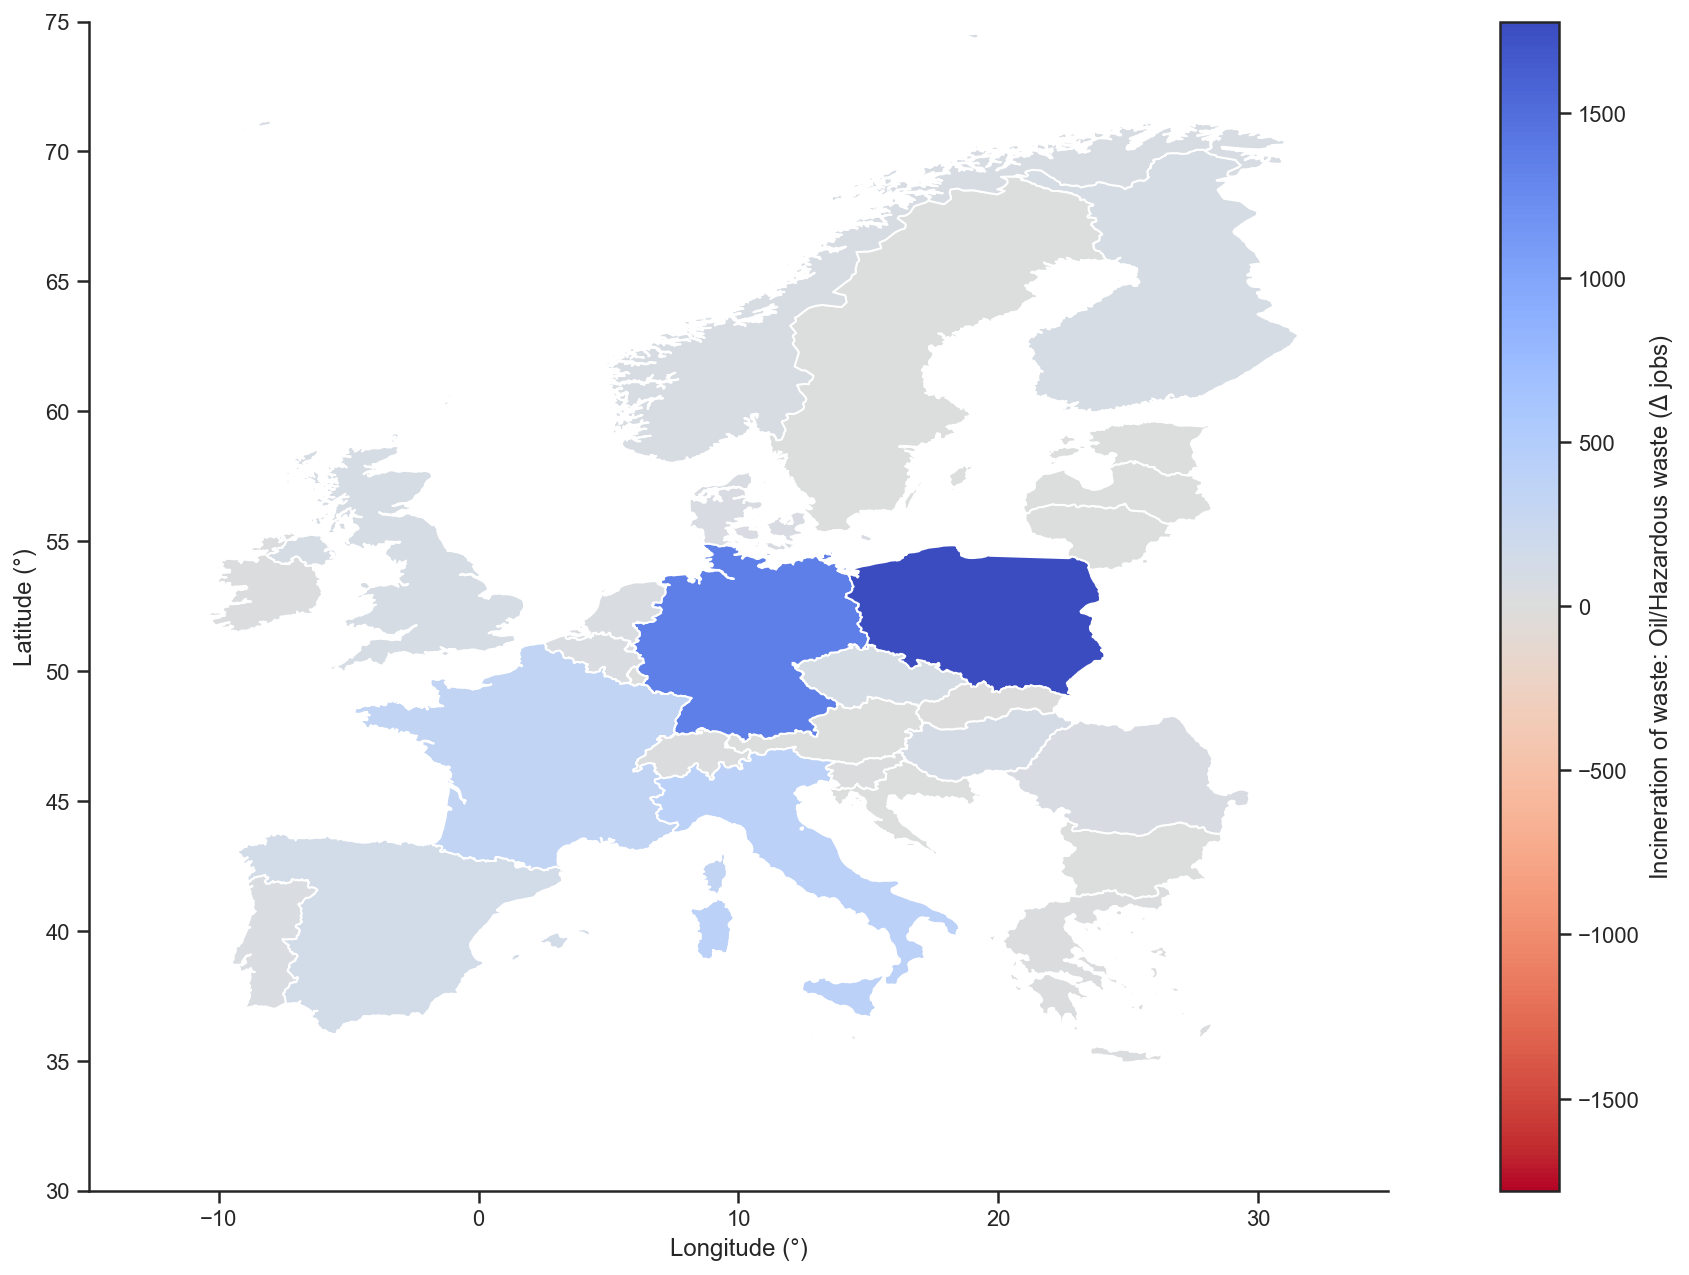

In [62]:
col = 'Employment: Total'

for subset_sector, subset_code in zip(gdf_delta.index.get_level_values("sector").unique(),
                                      gdf_delta.index.get_level_values("sector_code").unique()):
    print(subset_code, subset_sector)

    data = gdf_delta.dropna(subset=["admin"]).query("sector == '{}'".format(subset_sector))
    normval = np.max([np.abs(data[col].min()), np.abs(data[col].max())])
    # no change case
    if normval == 0:
        continue
    divnorm = mpl.colors.TwoSlopeNorm(vcenter=0, vmin=-normval, vmax=normval)

    ax = data.plot(
        column=col,
        legend=True,
        legend_kwds={'label': "{} ($\Delta$ jobs)".format(subset_sector)},
        cmap="coolwarm_r",
        norm=divnorm
    )

    ax.set_xlabel("Longitude (°)")
    ax.set_ylabel("Latitude (°)")

    ax.set_xlim(-15, 35)
    ax.set_ylim(30, 75)

    sns.despine()
    plt.tight_layout()
    plt.savefig(
        os.path.join(figure_dir, "ilo_es_maps", "{}_{}.png".format(subset_code, "_".join(subset_sector.split(" ")))),
        dpi=150,
        bbox_inches="tight"
    )
    plt.close()

0.0